### 📈 Curvature Optimization

Once the spline is built:
- You must **replace the assumed boundary conditions** (like natural spline: second derivative = 0 at endpoints).
- Your goal is to **optimize** the spline such that the **total curvature is minimized**.
- This will result in a **smoother path**—which is desirable for autonomous vehicle trajectory planning.


### 🔍 What does Optimization mean here?
There are 3 parts to an optimization problem:
- Objective (or Cost) Function :
This is the function you want to minimize or maximize.
- Parameters (or Decision Variables):
These are the variables you are allowed to change in order to achieve the best value of the objective.
- Constraints:
These are the rules or limits that the parameters and/or the solution must satisfy.
In general, optimization means adjusting parameters to minimize or maximize an objective — like reducing cost, increasing speed, or in our case: minimizing curvature.

Here, you are given 4 fixed waypoints. Your goal is to interpolate these points using cubic splines, but with a twist:

refer to the first 3 videos of the following playlist for a better understanding:
[Video: Introduction to Curve Optimization](https://youtube.com/playlist?list=PLLK3oSbvdxFdF67yVxF_1FQO9SbBY3yTL&si=EMnkQ3Gb_EleDISu)

---
## 🎯 PROBLEM STATEMENT
You are given 4 discrete waypoints from the previous section. Your task is to interpolate these points using **cubic spline interpolation**, but with a focus on **optimizing the shape of the curve**.

Essentially, you are required to **minimize the total curvature** of the resulting spline by **varying the second derivative values at the boundaries**. This should be done **without using inbuilt spline functions** from libraries such as `scipy`. The goal is to find the **smoothest possible path** through the points, which would represent the **ideal trajectory** for a vehicle to follow. You may choose suitable bounds for the second derivative values and iterate through different combinations of boundary conditions to determine the configuration that leads to the **minimum total curvature**.

---

## Curvature Formula

The **curvature** $\kappa(t)$ of a 2D parametric curve $(x(t), y(t))$ is given by:

$$
\kappa(t) = \frac{ |x'(t)y''(t) - y'(t)x''(t)| }{ \left( (x'(t))^2 + (y'(t))^2 \right)^{3/2} }
$$

Where:
- $x'(t)$ and $y'(t)$ are the **first derivatives** with respect to the parameter $t$
- $x''(t)$ and $y''(t)$ are the **second derivatives**

---

## 📌 Deliverables

1. Your own implementation of cubic spline interpolation.
2. Plots of:
   - Original points
   - Interpolated spline without optimization
   - Interpolated spline with optimization
---

### 🌟 Optional Assignement

You may notice that directly finding the smoothest curve through waypoints seems inefficient and computationally expensive. Fortunately, mathematicians have developed robust optimization techniques that are readily available through libraries like `scipy.optimize`.

In this task, try enhancing the **cubic interpolation curve** you obtained earlier by finding an **optimal trajectory through the waypoints** — one that minimizes the curvature at every interpolated point. To do this, you can treat the **second derivatives at the curve’s boundaries** as variables to be optimized. Use `scipy` functions to perform this optimization and compare the resulting smooth curve to the original interpolation.

However, you may not notice an appreciable reduction in sharpness and a smoother, more natural path. What else can be done then for the **optimal raceline** for our car?

---

**Good luck!**  Let the paths be smooth and the math be satisfying!

Optimal endpoint second derivative: 0.00, Curvature measure: 2.3214


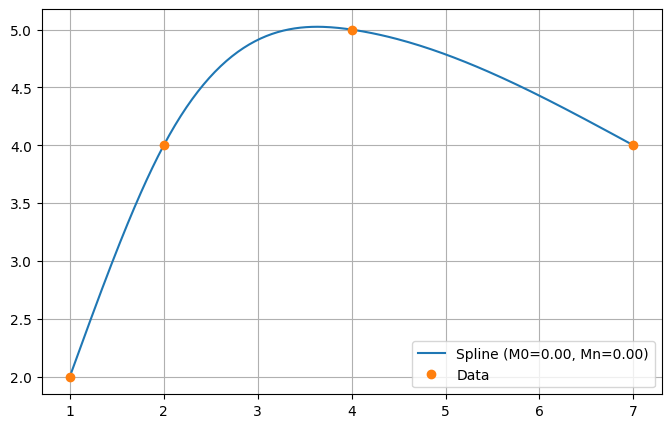

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def cubic_spline_interpolation(x, y, M0=0.0, Mn=0.0, dense_points=100, plot=True):
    """
    Perform cubic spline interpolation with given endpoint second derivatives M0 and Mn.

    Parameters:
    -----------
    x : array-like, shape (n,)
        Strictly increasing x-coordinates of the data points.
    y : array-like, shape (n,)
        y-coordinates of the data points.
    M0, Mn : float
        Prescribed second derivatives at the first and last knots.
    dense_points : int
        Number of sample points per interval for plotting.
    plot : bool
        Whether to plot the resulting spline and data points.

    Returns:
    --------
    xs_dense : ndarray
        Dense x-coordinates for the full interpolant.
    ys_dense : ndarray
        Corresponding y-values of the spline.
    M : ndarray
        Array of second derivatives at each knot.
    """
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    n = len(x)
    if n < 2:
        raise ValueError("Need at least two points for interpolation")
    if not np.all(np.diff(x) > 0):
        raise ValueError("x must be strictly increasing")

    h = np.diff(x)
    # Build tridiagonal system for M[1..n-2]
    if n > 2:
        A = np.zeros((n-2, n-2))
        rhs = np.zeros(n-2)
        for i in range(1, n-1):
            row = i-1
            if i > 1:
                A[row, row-1] = h[i-1]
            A[row, row] = 2*(h[i-1] + h[i])
            if i < n-2:
                A[row, row+1] = h[i]
            # original RHS term
            rhs[row] = 6 * ((y[i+1] - y[i]) / h[i] - (y[i] - y[i-1]) / h[i-1])
        # adjust for boundary conditions
        rhs[0] -= h[0] * M0
        rhs[-1] -= h[-1] * Mn
        M_interior = np.linalg.solve(A, rhs)
        M = np.zeros(n)
        M[0] = M0
        M[1:-1] = M_interior
        M[-1] = Mn
    else:
        # only two points: linear segment
        M = np.array([M0, Mn], dtype=float)

    # function to evaluate on each segment
    def seg_val(i, x_val):
        xi, xi1 = x[i], x[i+1]
        yi, yi1 = y[i], y[i+1]
        Mi, Mi1 = M[i], M[i+1]
        h_i = xi1 - xi
        t1 = (Mi/(6*h_i)) * (xi1 - x_val)**3
        t2 = (Mi1/(6*h_i)) * (x_val - xi)**3
        t3 = (yi/h_i - Mi*h_i/6) * (xi1 - x_val)
        t4 = (yi1/h_i - Mi1*h_i/6) * (x_val - xi)
        return t1 + t2 + t3 + t4

    xs_dense = []
    ys_dense = []
    for i in range(n-1):
        xi, xi1 = x[i], x[i+1]
        x_vals = np.linspace(xi, xi1, dense_points)
        y_vals = seg_val(i, x_vals)
        xs_dense.append(x_vals)
        ys_dense.append(y_vals)
    xs_dense = np.concatenate(xs_dense)
    ys_dense = np.concatenate(ys_dense)

    if plot:
        plt.figure(figsize=(8,5))
        plt.plot(xs_dense, ys_dense, label=f'Spline (M0={M0:.2f}, Mn={Mn:.2f})')
        plt.plot(x, y, 'o', label='Data')
        plt.legend()
        plt.grid(True)
        plt.show()

    return xs_dense, ys_dense, M


def curvature_measure(x, M):
    """
    Approximate the integral of squared second derivative over the knots.
    Uses formula: sum(h_i/3 * (M_i^2 + M_i * M_{i+1} + M_{i+1}^2)).
    Parameters:
    -----------
    x : array-like, shape (n,)
        Knot positions.
    M : array-like, shape (n,)
        Second derivatives at knots.
    Returns:
    --------
    J : float
        Approximate curvature measure.
    """
    x = np.array(x, dtype=float)
    M = np.array(M, dtype=float)
    h = np.diff(x)
    J = 0.0
    for i in range(len(h)):
        J += h[i]/3 * (M[i]**2 + M[i]*M[i+1] + M[i+1]**2)
    return J


def find_optimal_boundary(x, y, k_values=np.linspace(-100,100,201)):
    """
    Sweep endpoint second derivative k from list of values, find k that minimizes curvature.
    Assumes M0 = Mn = k.
    Returns optimal k and corresponding J.
    """
    best_k = None
    best_J = np.inf
    for k in k_values:
        _, _, M = cubic_spline_interpolation(x, y, M0=k, Mn=k, dense_points=2, plot=False)
        J = curvature_measure(x, M)
        if J < best_J:
            best_J = J
            best_k = k
    return best_k, best_J

# Example usage:
if __name__ == '__main__':
    x = [1.0, 2.0, 4.0, 7.0]
    y = [2.0, 4.0, 5.0, 4.0]

    # find optimal boundary
    k_opt, J_opt = find_optimal_boundary(x, y)
    print(f"Optimal endpoint second derivative: {k_opt:.2f}, Curvature measure: {J_opt:.4f}")

    # interpolate with optimal k
    xs, ys, M = cubic_spline_interpolation(x, y, M0=k_opt, Mn=k_opt)
